##  Importation des données dans InfluxDB

In [53]:
import pandas as pd

In [54]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## InfluxDB

In [55]:
from influxdb import DataFrameClient

In [58]:
# see https://influxdb-python.readthedocs.io/en/latest/examples.html#tutorials-pandas
"""Instantiate the connection to the InfluxDB client."""

host, port = 'localhost', 8086
user, password = 'root', 'root'
dbname = 'weatherdata'
protocol = 'line'

CLIENT = DataFrameClient(host, port, user, password, dbname)

In [57]:

#print("Create database: " + dbname)
#CLIENT.create_database(dbname)

# /!\ delete /!\
# CLIENT.drop_database( dbname  )

In [6]:
coords = (45.1973288, 5.7139923)

In [7]:
firstday = '2017-11-05'
lastday = '2017-11-10'

daterange = pd.date_range(start=firstday, end=lastday,  freq='D', normalize=True)
daterange_iso = daterange.strftime('%Y-%m-%dT%H:%M:%SZ')

## Darksky

In [8]:
from darksky import forecast

# """ You get 1,000 API calls for free each day. """

# Load the API key for darksky
with open('darksky_key.txt') as f:
    KEY = f.read()

EXCLUDE = ['currently', 'minutely', 'daily', 'flags']  # from the query

In [9]:
def query2dataframe( coords,  day ):
    # query
    data = forecast(KEY, *coords, units='si', lang='fr', time=day, exclude=EXCLUDE)
    
    print('get data for %s' % day)
    
    # build the DataFrame from records (dict)
    records = data['hourly']['data']  
    weatherdataDF = pd.DataFrame.from_records(records, index='time')

    weatherdataDF.index = pd.to_datetime(weatherdataDF.index, unit='s')
    
    # debug: force les valeurs en flottant  ( plutôt que Int à cause des NaN ) 
    cols_int = list( weatherdataDF.select_dtypes(include=['int']).columns )
    for c in cols_int:
        weatherdataDF[c] = weatherdataDF[c].dropna().astype(float)
        
    return weatherdataDF

In [10]:
def dataFrame2influx( measurement_name, DF ):
    # Ajoute colone par colones pour retirer les NaN...
    for c in DF.columns:
        CLIENT.write_points(DF[[c]].dropna(), measurement_name)
        
def add1day( measurement_name, coords, day ):
    weatherdataDF = query2dataframe( coords,  day )
    dataFrame2influx( measurement_name, weatherdataDF )

In [11]:
measurement_name = 'darksky'

In [12]:
for d in daterange_iso:
    add1day( measurement_name, coords, d )

get data for 2017-11-05T00:00:00Z
get data for 2017-11-06T00:00:00Z
get data for 2017-11-07T00:00:00Z
get data for 2017-11-08T00:00:00Z
get data for 2017-11-09T00:00:00Z
get data for 2017-11-10T00:00:00Z


### debug

In [370]:
weatherdataDF = query2dataframe( coords,  '2017-09-02T00:00:00Z' )

get data for 2017-09-02T00:00:00Z


## EmonCMS

In [59]:
import emoncmsfeed as getfeeds

In [60]:
dataframefreq = '15min'
feeds =  { 'T_int': 3 }

In [61]:
measurement_name = 'openenergymonitor'

In [40]:
for date in daterange:
    startday = date
    lastday = date + pd.to_timedelta('1d')
    
    startday_iso = startday.strftime('%Y-%m-%dT%H:%M:%SZ')
    lastday_iso = lastday.strftime('%Y-%m-%dT%H:%M:%SZ')
    
    data = getfeeds.builddataframe( feeds, dataframefreq , startdate=startday, enddate=lastday )
    
    # cas jour sans donnée
    if len( data ) == 0 :
        print('no data %s'%daterange_iso[i])
        continue
    
    # Ajoute colone par colones pour retirer les NaN...
    for c in data.columns:
        CLIENT.write_points(data[[c]].dropna(), measurement_name)

### debug

In [35]:
startday

Timestamp('2017-11-10 00:00:00', freq='D')

In [48]:
pd.Timestamp("today")

Timestamp('2017-11-11 14:29:49.098003')

In [62]:
startday = pd.to_datetime('2017-11-10T00:00:00Z', format='%Y-%m-%dT%H:%M:%SZ')
lastday = pd.to_datetime('2017-11-11T09:00:00Z', format='%Y-%m-%dT%H:%M:%SZ')
lastday = pd.Timestamp("today")

In [50]:
data = getfeeds.builddataframe( feeds, dataframefreq , startdate=startday, enddate=lastday )

In [51]:
# Ajoute colone par colones pour retirer les NaN...
for c in data.columns:
    CLIENT.write_points(data[[c]].dropna(), measurement_name)

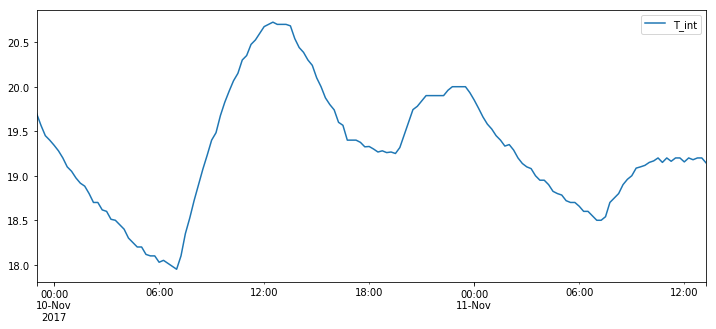

In [52]:
data.plot(figsize=(12, 5))

# Irradiation solaire

In [18]:
import sunradiation as sun

In [19]:
query = 'SELECT cloudCover FROM darksky'

In [20]:
cloudcover = CLIENT.query(query)
cloudcoverDF = cloudcover['darksky']

In [21]:
cloudcoverDF = cloudcoverDF.resample('15min').interpolate()

In [22]:
sundata = sun.buildmultidayDF( coords, cloudcoverDF.index, cloudCover = cloudcoverDF['cloudCover']  )

/home/etienne/Projets/thermique_appart/py3/lib/python3.5/site-packages/pysolar/time.py:105: UserWarning: I don't know about leap seconds after 2015
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


In [23]:
measurement_name = 'sundata'

# Ajoute colone par colones pour retirer les NaN...
for c in sundata.columns:
    CLIENT.write_points(sundata[[c]].dropna(), measurement_name)

### Projection sur les surfaces vitrées

In [24]:
# surface (m2),  sigma (deg),  azimuth (deg)
windows = { 'bastille':(1.2*0.8,    37, 50),
            'cuisine': (0.3*0.72 *2, 90, 50 ),
            'chambre': (0.3*0.72 *2, 90, 180+50),
            'vercors': (0.6*0.8 * 2, 37, 180+50) }

In [25]:
sunFlux_dict = {}

for k, values in windows.items():
    sunFlux_dict['flux_'+k] = values[0] * sun.projectDF( values[1], values[2], sundata )

sunFlux_DF = pd.DataFrame( sunFlux_dict )

# Somme
sunFlux_DF['flux_tot'] = sunFlux_DF.sum(axis=1)

In [26]:
measurement_name = 'sundata'

# Ajoute colone par colones pour retirer les NaN...
for c in sunFlux_DF.columns:
    CLIENT.write_points(sunFlux_DF[[c]].dropna(), measurement_name)